# Create Keras Model
CoreMLTools needs a keras model to convert instead of a tensorflow.keras model😒 so this notebook is for creating a keras model.

#### Imports and functions

In [1]:
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Activation
from keras import layers
from keras.models import Sequential
from keras import callbacks
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import pdb

train_path = '..//data//helen//train_rotated//'
test_path = '..//data//helen//test_rotated//'
num_classes = 4


def plot_figures(figures, nrows=1, ncols=1, size=8):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(
        ncols=ncols, nrows=nrows, figsize=(size, size))
    for ind, title in enumerate(figures):
        axeslist[ind].imshow(figures[title], cmap=plt.gray())
        axeslist[ind].set_title(title)
        axeslist[ind].set_axis_off()
    plt.tight_layout()  # optional


def plot_train_history(history):
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


x_train = np.load(train_path+'x_train_rotated_bilinear.npy')
y_train = np.load(train_path+'y_train_rotated_bilinear.npy')
x_test = np.load(test_path+'x_test_rotated_bilinear.npy')
y_test = np.load(test_path+'y_test_rotated_bilinear.npy')

Using TensorFlow backend.


# Current Best - VGG (standardized, Adam) - 33,512 - 0.9652 (epoch 167)
Scaling - Standardize (subtract mean pixel value and divide by standard deviation)

Optimizer - Adam

#### Define Train function

In [2]:
my_callbacks = [callbacks.EarlyStopping(monitor='val_acc', patience=18, verbose=1, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=5, min_lr=1e-9, mode='auto', verbose=1)]

def train(model, epochs=100, initial_epoch=0, batch_size=128, lr=0.01, opt=None, plot_hist='True'):
    if not opt:   # if opt is None,
        opt = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

#     can test augmentation techniques like brightness and rotation
    train_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    train_generator.fit(x_train)
    train_generator = train_generator.flow(x_train, y_train, seed=11, batch_size=batch_size, shuffle=True)
    validation_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    validation_generator.fit(x_train)
    validation_generator = validation_generator.flow(x_test, y_test, seed=11, batch_size=batch_size, shuffle=True)

    history = model.fit_generator(generator=train_generator,
                                  epochs=epochs+initial_epoch,
                                  verbose=1,
                                  callbacks=my_callbacks,
                                  validation_data=validation_generator,
                                  shuffle=True,
                                  initial_epoch=initial_epoch)
    if(plot_hist):
        plot_train_history(history)
                
    index = history.history['val_acc'].index(max(history.history['val_acc']))
    print('Best val_acc - {:.4} (epoch {:})'.format(history.history['val_acc'][index], index+1))
    return history, model

#### Define Model

In [3]:
model_6 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(20, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(20, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(20, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(20, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(20, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(16),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_6.summary()

W0909 10:59:37.596852 13988 deprecation_wrapper.py:119] From C:\Users\kendy\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0909 10:59:37.611840 13988 deprecation_wrapper.py:119] From C:\Users\kendy\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0909 10:59:37.614804 13988 deprecation_wrapper.py:119] From C:\Users\kendy\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0909 10:59:37.643727 13988 deprecation_wrapper.py:119] From C:\Users\kendy\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instea

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 20)      2900      
_________________________________________________________________
batch_normalization_2 (Batch (None, 124, 124, 20)      80        
_________________________________________________________________
activation_2 (Activation)    (None, 124, 124, 20)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 20)       

#### Execute Training

W0906 14:46:08.168560  8664 deprecation_wrapper.py:119] From C:\Users\kendy\Anaconda3\envs\keras-gpu\lib\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0906 14:46:27.730760  8664 deprecation.py:323] From C:\Users\kendy\Anaconda3\envs\keras-gpu\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
63/63 [==============================] - 9s 136ms/step - loss: 1.9528 - acc: 0.2542 - val_loss: 1.3934 - val_acc: 0.2856
Epoch 2/100
63/63 [==============================] - 5s 80ms/step - loss: 1.6521 - acc: 0.2716 - val_loss: 1.3732 - val_acc: 0.3152
Epoch 3/100
63/63 [==============================] - 5s 81ms/step - loss: 1.5294 - acc: 0.2847 - val_loss: 1.3702 - val_acc: 0.3311
Epoch 4/100
63/63 [==============================] - 5s 80ms/step - loss: 1.4647 - acc: 0.2822 - val_loss: 1.3744 - val_acc: 0.3288
Epoch 5/100
63/63 [==============================] - 5s 80ms/step - loss: 1.4271 - acc: 0.2954 - val_loss: 1.3774 - val_acc: 0.3023
Epoch 6/100
63/63 [==============================] - 5s 80ms/step - loss: 1.4067 - acc: 0.2934 - val_loss: 1.3784 - val_acc: 0.3008
Epoch 7/100
63/63 [==============================] - 5s 80ms/step - loss: 1.3981 - acc: 0.2844 - val_loss: 1.3768 - val_acc: 0.2917
Epoch 8/100
63/63 [==============================] - 5s 80ms/step - loss: 1

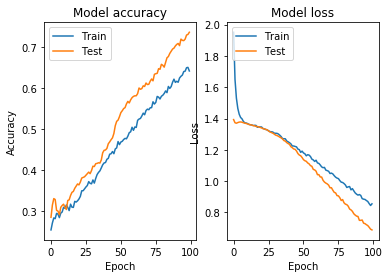

Best val_acc - 0.7356 (epoch 100)


In [5]:
# lower the learning rate by a factor of 10
history, model_6 = train(model_6, lr=0.0001)

Epoch 102/201
63/63 [==============================] - 6s 102ms/step - loss: 0.8329 - acc: 0.6550 - val_loss: 0.6780 - val_acc: 0.7311
Epoch 103/201
63/63 [==============================] - 5s 79ms/step - loss: 0.8170 - acc: 0.6621 - val_loss: 0.6384 - val_acc: 0.7598
Epoch 104/201
63/63 [==============================] - 5s 79ms/step - loss: 0.7724 - acc: 0.6827 - val_loss: 0.6317 - val_acc: 0.7591
Epoch 105/201
63/63 [==============================] - 5s 79ms/step - loss: 0.7664 - acc: 0.6902 - val_loss: 0.5923 - val_acc: 0.7795
Epoch 106/201
63/63 [==============================] - 5s 79ms/step - loss: 0.7426 - acc: 0.6983 - val_loss: 0.5640 - val_acc: 0.7894
Epoch 107/201
63/63 [==============================] - 5s 79ms/step - loss: 0.7045 - acc: 0.7102 - val_loss: 0.5599 - val_acc: 0.7795
Epoch 108/201
63/63 [==============================] - 5s 79ms/step - loss: 0.6800 - acc: 0.7290 - val_loss: 0.5261 - val_acc: 0.8023
Epoch 109/201
63/63 [==============================] - 5s 79m

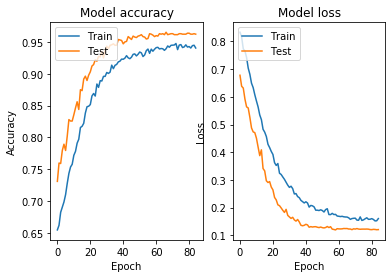

Best val_acc - 0.9652 (epoch 67)


In [6]:
history, model_6 = train(model_6, initial_epoch=101, lr=0.0001)

In [7]:
# save with the convention 'm[model number]_[# parameters]_[best val_acc].h5'
model_6.save('..//models//m6_33512_9652.h5')

# Test scaling

## Model 1: No scaling  - 0.9795 (epoch 42)

#### Define Train function

In [7]:
my_callbacks = [callbacks.EarlyStopping(monitor='val_acc', patience=15, verbose=1, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=1e-6, mode='auto', verbose=1)]

def train(model, epochs=200, initial_epoch=0, batch_size=128, lr=0.01, opt='adadelta', plot_hist='True'):
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

#     can test augmentation techniques like brightness and rotation
    train_generator = ImageDataGenerator().flow(x_train, y_train, batch_size=batch_size, seed=11)

    validation_generator = ImageDataGenerator().flow(x_test, y_test, batch_size=batch_size, seed=11)
#     train_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
#     train_generator.fit(x_train)
#     train_generator = train_generator.flow(x_train, y_train, seed=11, batch_size=batch_size)
#     validation_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
#     validation_generator.fit(x_train)
#     validation_generator = validation_generator.flow(x_test, y_test, seed=11, batch_size=batch_size)

    history = model.fit_generator(generator=train_generator,
                                  epochs=epochs+initial_epoch,
                                  verbose=1,
                                  callbacks=my_callbacks,
                                  validation_data=validation_generator,
                                  shuffle=True,
                                  initial_epoch=initial_epoch)
    if(plot_hist):
        plot_train_history(history)
                
    index = history.history['val_acc'].index(max(history.history['val_acc']))
    print('Best val_acc - {:.4} (epoch {:})'.format(history.history['val_acc'][index], index+1))
    return history, model

#### Define Model

In [6]:
model_1 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(20, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(20, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(20, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(20, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(20, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(16),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_9 (Batch (None, 126, 126, 16)      64        
_________________________________________________________________
activation_11 (Activation)   (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 124, 124, 20)      2900      
_________________________________________________________________
batch_normalization_10 (Batc (None, 124, 124, 20)      80        
_________________________________________________________________
activation_12 (Activation)   (None, 124, 124, 20)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 20)       

#### Execute Training

W0909 11:16:27.152717 13988 deprecation_wrapper.py:119] From C:\Users\kendy\Anaconda3\envs\keras-gpu\lib\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0909 11:16:28.282097 13988 deprecation.py:323] From C:\Users\kendy\Anaconda3\envs\keras-gpu\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/200
63/63 [==============================] - 9s 139ms/step - loss: 1.4401 - acc: 0.2649 - val_loss: 1.3662 - val_acc: 0.2765
Epoch 2/200
63/63 [==============================] - 5s 79ms/step - loss: 1.3530 - acc: 0.3043 - val_loss: 1.2303 - val_acc: 0.3583
Epoch 3/200
63/63 [==============================] - 5s 78ms/step - loss: 1.2282 - acc: 0.3757 - val_loss: 1.1238 - val_acc: 0.3992
Epoch 4/200
63/63 [==============================] - 5s 79ms/step - loss: 1.1284 - acc: 0.4173 - val_loss: 1.1097 - val_acc: 0.4402
Epoch 5/200
63/63 [==============================] - 5s 78ms/step - loss: 1.0436 - acc: 0.4886 - val_loss: 1.0151 - val_acc: 0.5508
Epoch 6/200
63/63 [==============================] - 5s 78ms/step - loss: 0.9264 - acc: 0.5569 - val_loss: 0.8087 - val_acc: 0.6636
Epoch 7/200
63/63 [==============================] - 5s 79ms/step - loss: 0.7866 - acc: 0.6388 - val_loss: 1.0718 - val_acc: 0.5492
Epoch 8/200
63/63 [==============================] - 5s 79ms/step - loss: 0

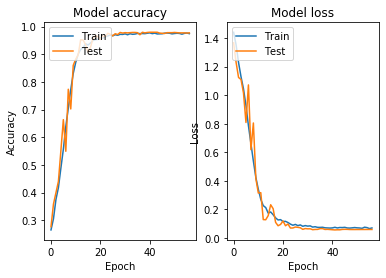

Best val_acc - 0.9795 (epoch 42)


In [8]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_1 = train(model_1, opt=opt)

In [9]:
# save with the convention 'm[model number]_[# parameters]_[best val_acc].h5'
model_1.save('..//models//m1_33512_9652.h5')

#### Predict validation set
Everything looks good. The predictions sum to one and it is predicting the correct class

In [ ]:
train_generator = ImageDataGenerator().flow(x_train, y_train, batch_size=32)

validation_generator = ImageDataGenerator().flow(x_test, y_test, batch_size=32)
batchx, batchy = validation_generator.next()

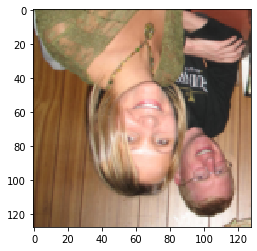

In [23]:
plt.imshow(batchx[3].astype(np.uint8))

In [24]:
batchx_pred = model_1.predict(batchx)
batchx_pred.shape

(32, 4)

In [25]:
batchx_pred[3].argmax()

2

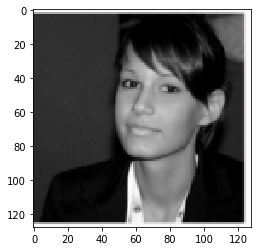

In [27]:
plt.imshow(batchx[0].astype(np.uint8))

In [29]:
batchx_pred[0].argmax()

0

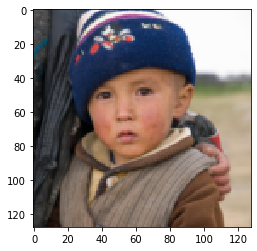

In [31]:
plt.imshow(batchx[1].astype(np.uint8))

In [32]:
batchx_pred[1].argmax()

0

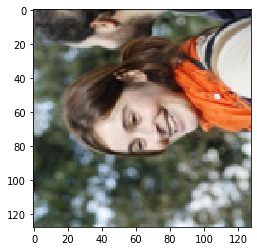

In [33]:
plt.imshow(batchx[2].astype(np.uint8))

In [34]:
batchx_pred[2].argmax()

3

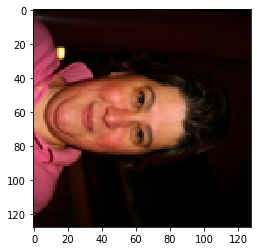

In [36]:
plt.imshow(batchx[5].astype(np.uint8))

In [37]:
batchx_pred[5].argmax()

1

In [30]:
batchx_pred[0].sum()

1.0000001

## Model 2: 1/255 scaling - 0.9909 (epoch 54)

#### Define Train function

In [39]:
my_callbacks = [callbacks.EarlyStopping(monitor='val_acc', patience=15, verbose=1, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=1e-6, mode='auto', verbose=1)]


def train(model, epochs=200, initial_epoch=0, batch_size=128, lr=0.01, opt='adadelta', plot_hist='True'):
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

#     can test augmentation techniques like brightness and rotation
    train_generator = ImageDataGenerator(zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
                                         channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=1/255, preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None).flow(x_train, y_train, batch_size=batch_size, seed=11)

    validation_generator = ImageDataGenerator(zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
                                              channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=1/255, preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None).flow(
        x_test, y_test, batch_size=batch_size, seed=11)

    history = model.fit_generator(generator=train_generator,
                                  epochs=epochs+initial_epoch,
                                  verbose=1,
                                  callbacks=my_callbacks,
                                  validation_data=validation_generator,
                                  shuffle=True,
                                  initial_epoch=initial_epoch)
    if(plot_hist):
        plot_train_history(history)

    index = history.history['val_acc'].index(max(history.history['val_acc']))
    print(
        'Best val_acc - {:.4} (epoch {:})'.format(history.history['val_acc'][index], index+1))
    return history, model

#### Define Model

In [40]:
model_2 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(20, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(20, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(20, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(20, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(20, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(16),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_17 (Batc (None, 126, 126, 16)      64        
_________________________________________________________________
activation_21 (Activation)   (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 124, 124, 20)      2900      
_________________________________________________________________
batch_normalization_18 (Batc (None, 124, 124, 20)      80        
_________________________________________________________________
activation_22 (Activation)   (None, 124, 124, 20)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 62, 62, 20)       

#### Execute Training

Epoch 1/200
63/63 [==============================] - 7s 108ms/step - loss: 1.5040 - acc: 0.2770 - val_loss: 1.3793 - val_acc: 0.2977
Epoch 2/200
63/63 [==============================] - 5s 79ms/step - loss: 1.3797 - acc: 0.2836 - val_loss: 1.3535 - val_acc: 0.3606
Epoch 3/200
63/63 [==============================] - 5s 78ms/step - loss: 1.3243 - acc: 0.3624 - val_loss: 1.2518 - val_acc: 0.3894
Epoch 4/200
63/63 [==============================] - 5s 78ms/step - loss: 1.2281 - acc: 0.4119 - val_loss: 1.2377 - val_acc: 0.4379
Epoch 5/200
63/63 [==============================] - 5s 78ms/step - loss: 1.1276 - acc: 0.4705 - val_loss: 1.0940 - val_acc: 0.5492
Epoch 6/200
63/63 [==============================] - 5s 79ms/step - loss: 1.0298 - acc: 0.5355 - val_loss: 0.9799 - val_acc: 0.5962
Epoch 7/200
63/63 [==============================] - 5s 79ms/step - loss: 0.8671 - acc: 0.6324 - val_loss: 1.3028 - val_acc: 0.5167
Epoch 8/200
63/63 [==============================] - 5s 79ms/step - loss: 0

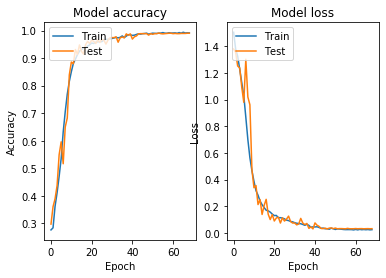

Best val_acc - 0.9909 (epoch 54)


In [41]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_2 = train(model_2, opt=opt)

In [42]:
# save with the convention 'm[model number]_[# parameters]_[best val_acc].h5'
model_2.save('..//models//m2_33512_9652.h5')

I have tested this bitch on an iPhone XS and it works beautifully 👌🔥

## Model 3: SHRINK IT 26,078 - 0.9879 (epoch 35)

#### Define Model

In [43]:
model_3 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(18, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(18, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(20, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(20, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(20, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(18, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(12),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_25 (Batc (None, 126, 126, 16)      64        
_________________________________________________________________
activation_31 (Activation)   (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 124, 124, 18)      2610      
_________________________________________________________________
batch_normalization_26 (Batc (None, 124, 124, 18)      72        
_________________________________________________________________
activation_32 (Activation)   (None, 124, 124, 18)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 62, 62, 18)       

#### Execute Training

Epoch 1/200
63/63 [==============================] - 7s 112ms/step - loss: 1.4558 - acc: 0.2610 - val_loss: 1.3841 - val_acc: 0.2667
Epoch 2/200
63/63 [==============================] - 5s 75ms/step - loss: 1.3786 - acc: 0.2793 - val_loss: 1.3810 - val_acc: 0.2758
Epoch 3/200
63/63 [==============================] - 5s 75ms/step - loss: 1.3624 - acc: 0.3125 - val_loss: 1.3674 - val_acc: 0.3152
Epoch 4/200
63/63 [==============================] - 5s 75ms/step - loss: 1.3266 - acc: 0.3655 - val_loss: 1.2933 - val_acc: 0.4189
Epoch 5/200
63/63 [==============================] - 5s 76ms/step - loss: 1.2600 - acc: 0.4282 - val_loss: 1.2915 - val_acc: 0.4205
Epoch 6/200
63/63 [==============================] - 5s 75ms/step - loss: 1.1498 - acc: 0.5091 - val_loss: 1.2012 - val_acc: 0.4682
Epoch 7/200
63/63 [==============================] - 5s 75ms/step - loss: 1.0045 - acc: 0.5868 - val_loss: 1.1472 - val_acc: 0.5318
Epoch 8/200
63/63 [==============================] - 5s 75ms/step - loss: 0

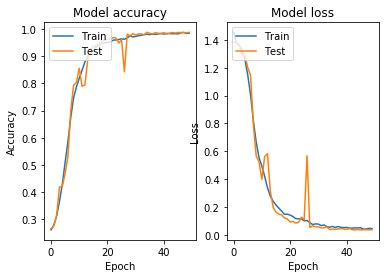

Best val_acc - 0.9879 (epoch 35)


In [44]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_3 = train(model_3, opt=opt)

## Model 4: Robust 26,078 
I tested model 2 on my iPhone XS and I noticed that it would only get it right if the subject's face was in the middle of the view. Adding in random rotation and random horizontal and vertical shifts. Same model as m3

#### Define Train function

In [49]:
my_callbacks = [callbacks.EarlyStopping(monitor='val_acc', patience=10, verbose=1, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=1e-6, mode='auto', verbose=1)]


def train(model, epochs=200, initial_epoch=0, batch_size=128, lr=0.01, opt='adadelta', plot_hist='True'):
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

#     can test augmentation techniques like brightness and rotation
    train_generator = ImageDataGenerator(zca_whitening=False, zca_epsilon=1e-06, rotation_range=5, width_shift_range=0.01, height_shift_range=0.01, brightness_range=None, shear_range=0.0, zoom_range=0.0,
                                         channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=1/255, preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None).flow(x_train, y_train, batch_size=batch_size, seed=11)

    validation_generator = ImageDataGenerator(zca_whitening=False, zca_epsilon=1e-06, rotation_range=5, width_shift_range=0.01, height_shift_range=0.01, brightness_range=None, shear_range=0.0, zoom_range=0.0,
                                              channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=1/255, preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None).flow(
        x_test, y_test, batch_size=batch_size, seed=11)

    history = model.fit_generator(generator=train_generator,
                                  epochs=epochs+initial_epoch,
                                  verbose=1,
                                  callbacks=my_callbacks,
                                  validation_data=validation_generator,
                                  shuffle=True,
                                  initial_epoch=initial_epoch)
    if(plot_hist):
        plot_train_history(history)

    index = history.history['val_acc'].index(max(history.history['val_acc']))
    print(
        'Best val_acc - {:.4} (epoch {:})'.format(history.history['val_acc'][index], index+1))
    return history, model

#### Define Model

In [50]:
model_4 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(18, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(18, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(20, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(20, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(20, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(18, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(12),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_4.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_49 (Batc (None, 126, 126, 16)      64        
_________________________________________________________________
activation_61 (Activation)   (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 124, 124, 18)      2610      
_________________________________________________________________
batch_normalization_50 (Batc (None, 124, 124, 18)      72        
_________________________________________________________________
activation_62 (Activation)   (None, 124, 124, 18)      0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 62, 62, 18)       

#### Execute Training

Epoch 1/200
63/63 [==============================] - 22s 353ms/step - loss: 1.4400 - acc: 0.2546 - val_loss: 1.3861 - val_acc: 0.2523
Epoch 2/200
63/63 [==============================] - 22s 343ms/step - loss: 1.3877 - acc: 0.2452 - val_loss: 1.3861 - val_acc: 0.2530
Epoch 3/200
63/63 [==============================] - 22s 348ms/step - loss: 1.3874 - acc: 0.2511 - val_loss: 1.3863 - val_acc: 0.2500
Epoch 4/200
63/63 [==============================] - 22s 351ms/step - loss: 1.3866 - acc: 0.2464 - val_loss: 1.3863 - val_acc: 0.2492
Epoch 5/200
63/63 [==============================] - 22s 348ms/step - loss: 1.3857 - acc: 0.2551 - val_loss: 1.3862 - val_acc: 0.2492
Epoch 6/200
63/63 [==============================] - 24s 384ms/step - loss: 1.3860 - acc: 0.2550 - val_loss: 1.3856 - val_acc: 0.2545
Epoch 7/200
63/63 [==============================] - 23s 359ms/step - loss: 1.3861 - acc: 0.2545 - val_loss: 1.3845 - val_acc: 0.2727
Epoch 8/200
63/63 [==============================] - 22s 347ms

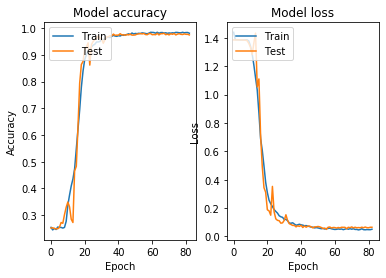

Best val_acc - 0.9803 (epoch 68)


In [51]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_4 = train(model_4, opt=opt)

In [52]:
# save with the convention 'm[model number]_[# parameters]_[best val_acc].h5'
model_4.save('..//models//m4_26078_0.9803.h5')

## Model 5: Robust 26,078 
Adding more range to the randomness

#### Define Train function

In [53]:
my_callbacks = [callbacks.EarlyStopping(monitor='val_acc', patience=10, verbose=1, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=1e-6, mode='auto', verbose=1)]


def train(model, epochs=200, initial_epoch=0, batch_size=128, lr=0.01, opt='adadelta', plot_hist='True'):
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

#     can test augmentation techniques like brightness and rotation
    train_generator = ImageDataGenerator(zca_whitening=False, zca_epsilon=1e-06, rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, brightness_range=None, shear_range=0.0, zoom_range=0.0,
                                         channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=1/255, preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None).flow(x_train, y_train, batch_size=batch_size, seed=11)

    validation_generator = ImageDataGenerator(zca_whitening=False, zca_epsilon=1e-06, rotation_range=5, width_shift_range=0.01, height_shift_range=0.01, brightness_range=None, shear_range=0.0, zoom_range=0.0,
                                              channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=1/255, preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None).flow(
        x_test, y_test, batch_size=batch_size, seed=11)

    history = model.fit_generator(generator=train_generator,
                                  epochs=epochs+initial_epoch,
                                  verbose=1,
                                  callbacks=my_callbacks,
                                  validation_data=validation_generator,
                                  shuffle=True,
                                  initial_epoch=initial_epoch)
    if(plot_hist):
        plot_train_history(history)

    index = history.history['val_acc'].index(max(history.history['val_acc']))
    print(
        'Best val_acc - {:.4} (epoch {:})'.format(history.history['val_acc'][index], index+1))
    return history, model

#### Define Model

In [54]:
model_5 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(18, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(18, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(20, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(20, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(20, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(18, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(12),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_5.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_57 (Batc (None, 126, 126, 16)      64        
_________________________________________________________________
activation_71 (Activation)   (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 124, 124, 18)      2610      
_________________________________________________________________
batch_normalization_58 (Batc (None, 124, 124, 18)      72        
_________________________________________________________________
activation_72 (Activation)   (None, 124, 124, 18)      0         
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 62, 62, 18)       

#### Execute Training

Epoch 1/200
63/63 [==============================] - 23s 371ms/step - loss: 1.6501 - acc: 0.2701 - val_loss: 1.3779 - val_acc: 0.2795
Epoch 2/200
63/63 [==============================] - 22s 347ms/step - loss: 1.3981 - acc: 0.2651 - val_loss: 1.3825 - val_acc: 0.2606
Epoch 3/200
63/63 [==============================] - 23s 367ms/step - loss: 1.3912 - acc: 0.2574 - val_loss: 1.3846 - val_acc: 0.2735
Epoch 4/200
63/63 [==============================] - 22s 354ms/step - loss: 1.3870 - acc: 0.2582 - val_loss: 1.3868 - val_acc: 0.2674
Epoch 5/200
63/63 [==============================] - 23s 358ms/step - loss: 1.3840 - acc: 0.2615 - val_loss: 1.3827 - val_acc: 0.2682

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/200
63/63 [==============================] - 23s 363ms/step - loss: 1.3744 - acc: 0.2848 - val_loss: 1.3763 - val_acc: 0.2985
Epoch 7/200
63/63 [==============================] - 24s 384ms/step - loss: 1.3666 - acc: 0.3036 - val_loss: 1.3691

Epoch 60/200
63/63 [==============================] - 22s 353ms/step - loss: 0.1524 - acc: 0.9447 - val_loss: 0.0566 - val_acc: 0.9833
Epoch 61/200
63/63 [==============================] - 23s 361ms/step - loss: 0.1465 - acc: 0.9456 - val_loss: 0.0577 - val_acc: 0.9848
Epoch 62/200
63/63 [==============================] - 22s 350ms/step - loss: 0.1391 - acc: 0.9494 - val_loss: 0.0564 - val_acc: 0.9833
Epoch 63/200
63/63 [==============================] - 23s 373ms/step - loss: 0.1457 - acc: 0.9489 - val_loss: 0.0584 - val_acc: 0.9826
Epoch 64/200
63/63 [==============================] - 22s 351ms/step - loss: 0.1502 - acc: 0.9431 - val_loss: 0.0604 - val_acc: 0.9811
Epoch 65/200
63/63 [==============================] - 23s 373ms/step - loss: 0.1422 - acc: 0.9478 - val_loss: 0.0538 - val_acc: 0.9818

Epoch 00065: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 66/200
63/63 [==============================] - 23s 358ms/step - loss: 0.1453 - acc: 0.9470 - val_loss: 

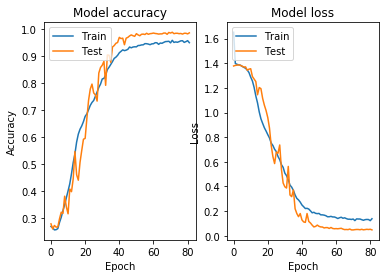

Best val_acc - 0.9879 (epoch 72)


In [55]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_5 = train(model_5, opt=opt)

In [56]:
# save with the convention 'm[model number]_[# parameters]_[best val_acc].h5'
model_5.save('..//models//m5_26078_9879.h5')

## Model 6: Brightness range 23,090 - 0.997 (epoch 80)

#### Define Train function

In [2]:
my_callbacks = [callbacks.EarlyStopping(monitor='val_acc', patience=10, verbose=1, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=1e-6, mode='auto', verbose=1)]


def train(model, epochs=200, initial_epoch=0, batch_size=128, lr=0.01, opt='adadelta', plot_hist='True'):
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

#     can test augmentation techniques like brightness and rotation
    train_generator = ImageDataGenerator(rotation_range=10, width_shift_range=0.15, height_shift_range=0.15, brightness_range=[0.2, 1.2], shear_range=0.0, zoom_range=0.2, channel_shift_range=0.0, fill_mode='nearest', 
                                         horizontal_flip=False, vertical_flip=False, rescale=1/255, preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None).flow(x_train, y_train, batch_size=batch_size, seed=11)

    validation_generator = ImageDataGenerator(rotation_range=10, width_shift_range=0.15, height_shift_range=0.15, brightness_range=[0.2, 1.2], shear_range=0.0, zoom_range=0.2,
                                              channel_shift_range=0.0, fill_mode='nearest', horizontal_flip=False, vertical_flip=False, rescale=1/255, preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None).flow(
        x_test, y_test, batch_size=batch_size, seed=11)

    history = model.fit_generator(generator=train_generator,
                                  epochs=epochs+initial_epoch,
                                  verbose=1,
                                  callbacks=my_callbacks,
                                  validation_data=validation_generator,
                                  shuffle=True,
                                  initial_epoch=initial_epoch)
    if(plot_hist):
        plot_train_history(history)

    index = history.history['val_acc'].index(max(history.history['val_acc']))
    print(
        'Best val_acc - {:.4} (epoch {:})'.format(history.history['val_acc'][index], index+1))
    return history, model

#### Define Model

In [3]:
model_6 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(17, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(17, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(18, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(18, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(18, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(17, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(12),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_6.summary()

W0923 09:54:08.913126  8240 deprecation_wrapper.py:119] From C:\Users\kendy\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0923 09:54:08.929116  8240 deprecation_wrapper.py:119] From C:\Users\kendy\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0923 09:54:08.932082  8240 deprecation_wrapper.py:119] From C:\Users\kendy\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0923 09:54:08.961020  8240 deprecation_wrapper.py:119] From C:\Users\kendy\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instea

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 17)      2465      
_________________________________________________________________
batch_normalization_2 (Batch (None, 124, 124, 17)      68        
_________________________________________________________________
activation_2 (Activation)    (None, 124, 124, 17)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 17)       

#### Execute Training

W0923 09:54:15.959978  8240 deprecation_wrapper.py:119] From C:\Users\kendy\Anaconda3\envs\keras-gpu\lib\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0923 09:54:17.117884  8240 deprecation.py:323] From C:\Users\kendy\Anaconda3\envs\keras-gpu\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/200
63/63 [==============================] - 31s 496ms/step - loss: 1.4303 - acc: 0.2493 - val_loss: 1.3853 - val_acc: 0.2674
Epoch 2/200
63/63 [==============================] - 28s 439ms/step - loss: 1.3870 - acc: 0.2567 - val_loss: 1.3862 - val_acc: 0.2568
Epoch 3/200
63/63 [==============================] - 28s 443ms/step - loss: 1.3873 - acc: 0.2522 - val_loss: 1.3859 - val_acc: 0.2568
Epoch 4/200
63/63 [==============================] - 28s 445ms/step - loss: 1.3849 - acc: 0.2625 - val_loss: 1.3859 - val_acc: 0.2530
Epoch 5/200
63/63 [==============================] - 29s 456ms/step - loss: 1.3837 - acc: 0.2724 - val_loss: 1.3827 - val_acc: 0.2848
Epoch 6/200
63/63 [==============================] - 29s 467ms/step - loss: 1.3799 - acc: 0.2804 - val_loss: 1.3719 - val_acc: 0.3129
Epoch 7/200
63/63 [==============================] - 28s 448ms/step - loss: 1.3724 - acc: 0.3100 - val_loss: 1.3479 - val_acc: 0.3326
Epoch 8/200
63/63 [==============================] - 28s 446ms

63/63 [==============================] - 29s 456ms/step - loss: 0.0936 - acc: 0.9668 - val_loss: 0.0347 - val_acc: 0.9924
Epoch 62/200
63/63 [==============================] - 28s 443ms/step - loss: 0.0975 - acc: 0.9654 - val_loss: 0.0377 - val_acc: 0.9833
Epoch 63/200
63/63 [==============================] - 28s 444ms/step - loss: 0.1060 - acc: 0.9623 - val_loss: 0.0380 - val_acc: 0.9909
Epoch 64/200
63/63 [==============================] - 28s 444ms/step - loss: 0.1057 - acc: 0.9626 - val_loss: 0.0271 - val_acc: 0.9917
Epoch 65/200
63/63 [==============================] - 28s 441ms/step - loss: 0.0899 - acc: 0.9679 - val_loss: 0.0356 - val_acc: 0.9924

Epoch 00065: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 66/200
63/63 [==============================] - 28s 443ms/step - loss: 0.0865 - acc: 0.9716 - val_loss: 0.0368 - val_acc: 0.9902
Epoch 67/200
63/63 [==============================] - 28s 445ms/step - loss: 0.0866 - acc: 0.9671 - val_loss: 0.0260 - val

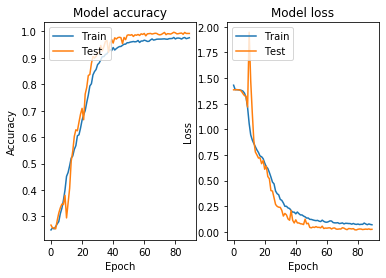

Best val_acc - 0.997 (epoch 80)


In [4]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_6 = train(model_6, opt=opt)

In [5]:
# save with the convention 'm[model number]_[# parameters]_[best val_acc].h5'
model_6.save('..//models//m6_23090_9970.h5')

## Model 7: Smaller? 23,090 

#### Define Train function

In [2]:
my_callbacks = [callbacks.EarlyStopping(monitor='val_acc', patience=10, verbose=1, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=1e-6, mode='auto', verbose=1)]


def train(model, epochs=200, initial_epoch=0, batch_size=128, lr=0.01, opt='adadelta', plot_hist='True'):
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

#     can test augmentation techniques like brightness and rotation
    train_generator = ImageDataGenerator(rotation_range=10, width_shift_range=0.15, height_shift_range=0.15, brightness_range=[0.2, 1.2], shear_range=0.0, zoom_range=0.2, channel_shift_range=0.0, fill_mode='nearest', 
                                         horizontal_flip=False, vertical_flip=False, rescale=1/255, preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None).flow(x_train, y_train, batch_size=batch_size, seed=11)

    validation_generator = ImageDataGenerator(rotation_range=10, width_shift_range=0.15, height_shift_range=0.15, brightness_range=[0.2, 1.2], shear_range=0.0, zoom_range=0.2,
                                              channel_shift_range=0.0, fill_mode='nearest', horizontal_flip=False, vertical_flip=False, rescale=1/255, preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None).flow(
        x_test, y_test, batch_size=batch_size, seed=11)

    history = model.fit_generator(generator=train_generator,
                                  epochs=epochs+initial_epoch,
                                  verbose=1,
                                  callbacks=my_callbacks,
                                  validation_data=validation_generator,
                                  shuffle=True,
                                  initial_epoch=initial_epoch)
    if(plot_hist):
        plot_train_history(history)

    index = history.history['val_acc'].index(max(history.history['val_acc']))
    print(
        'Best val_acc - {:.4} (epoch {:})'.format(history.history['val_acc'][index], index+1))
    return history, model

#### Define Model

In [10]:
model_7 = Sequential([
    Conv2D(15, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(15, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(15, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(17, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(15, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(15, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(11),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_7.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 126, 126, 15)      420       
_________________________________________________________________
batch_normalization_17 (Batc (None, 126, 126, 15)      60        
_________________________________________________________________
activation_21 (Activation)   (None, 126, 126, 15)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 124, 124, 15)      2040      
_________________________________________________________________
batch_normalization_18 (Batc (None, 124, 124, 15)      60        
_________________________________________________________________
activation_22 (Activation)   (None, 124, 124, 15)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 62, 62, 15)       

#### Execute Training

Epoch 1/200
63/63 [==============================] - 30s 478ms/step - loss: 1.5259 - acc: 0.2512 - val_loss: 1.3923 - val_acc: 0.2432
Epoch 2/200
63/63 [==============================] - 28s 452ms/step - loss: 1.3911 - acc: 0.2493 - val_loss: 1.3852 - val_acc: 0.2621
Epoch 3/200
63/63 [==============================] - 29s 456ms/step - loss: 1.3882 - acc: 0.2514 - val_loss: 1.3860 - val_acc: 0.2553
Epoch 4/200
63/63 [==============================] - 29s 459ms/step - loss: 1.3875 - acc: 0.2495 - val_loss: 1.3853 - val_acc: 0.2492
Epoch 5/200
63/63 [==============================] - 30s 479ms/step - loss: 1.3862 - acc: 0.2512 - val_loss: 1.3857 - val_acc: 0.2530
Epoch 6/200
63/63 [==============================] - 29s 467ms/step - loss: 1.3863 - acc: 0.2499 - val_loss: 1.3856 - val_acc: 0.2500

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/200
63/63 [==============================] - 28s 452ms/step - loss: 1.3866 - acc: 0.2458 - val_loss: 1.3860

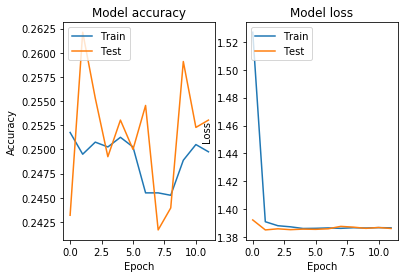

Best val_acc - 0.2621 (epoch 2)


In [11]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_7 = train(model_7, opt=opt)

In [5]:
# save with the convention 'm[model number]_[# parameters]_[best val_acc].h5'
model_6.save('..//models//m6_23090_9970.h5')

# Results
The fastest optimizer was Adam, achieving a val_acc of 0.9682 at epoch 28.
The best performing optimizer is also Adam, with a val_acc of 0.9697 at epoch 56 :)